In [1]:
# import os

# def list_directory_contents(root_path, files_per_dir=5):
#     for dirname, subdirs, filenames in os.walk(root_path):
#         # Print directory name
#         print(f"\nDirectory: {dirname}")
        
#         # Print limited number of files
#         print("Files:")
#         for filename in filenames[:files_per_dir]:
#             print(f"  - {os.path.join(dirname, filename)}")
            
#         # Show count if there are more files
#         remaining = len(filenames) - files_per_dir
#         if remaining > 0:
#             print(f"  ... and {remaining} more file(s)")

# # Usage example
# list_directory_contents('/kaggle/input')

In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification, ViTFeatureExtractor, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from PIL import Image

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Paths
dataset_path = "/kaggle/input/aid-scene-classification-datasets/AID"

# Load feature extractor first to use its normalization values
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Prepare dataset with ImageFolder
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Use the feature extractor's normalization values
    transforms.Normalize(
        mean=feature_extractor.image_mean,
        std=feature_extractor.image_std
    )
])

dataset = ImageFolder(root=dataset_path, transform=transform)

# Split dataset into training and validation sets
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
val_dataset = torch.utils.data.Subset(dataset, val_idx)

# Load Vision Transformer model
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(dataset.classes)
)
model.to(device)

# Modified collate function that doesn't apply additional normalization
def collate_fn(batch):
    images, labels = zip(*batch)
    # Stack the images into a batch tensor
    images = torch.stack(images)
    # Prepare the inputs as expected by ViT
    encodings = {
        'pixel_values': images,
        'labels': torch.tensor(labels)
    }
    return encodings

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,  # Added to save best model
    metric_for_best_model='eval_loss',  # Use eval loss to determine best model
    save_strategy='epoch',  # Save at each epoch
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model
evaluation_results = trainer.evaluate()
print(f"Evaluation Results: {evaluation_results}")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in y

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.315500,0.378530
2,0.145800,0.257582
3,0.148400,0.247773
4,0.177000,0.298069
5,0.073600,0.260984
6,0.005500,0.269909
7,0.001800,0.252229
8,0.067200,0.378560
9,0.028300,0.361946
10,0.038000,0.276401


Evaluation Results: {'eval_loss': 0.19881322979927063, 'eval_runtime': 30.7735, 'eval_samples_per_second': 64.991, 'eval_steps_per_second': 4.062, 'epoch': 20.0}


### WANDB_KEY = b6f1aaf5ae5f633a1b33a342a7bd88ae338825e7

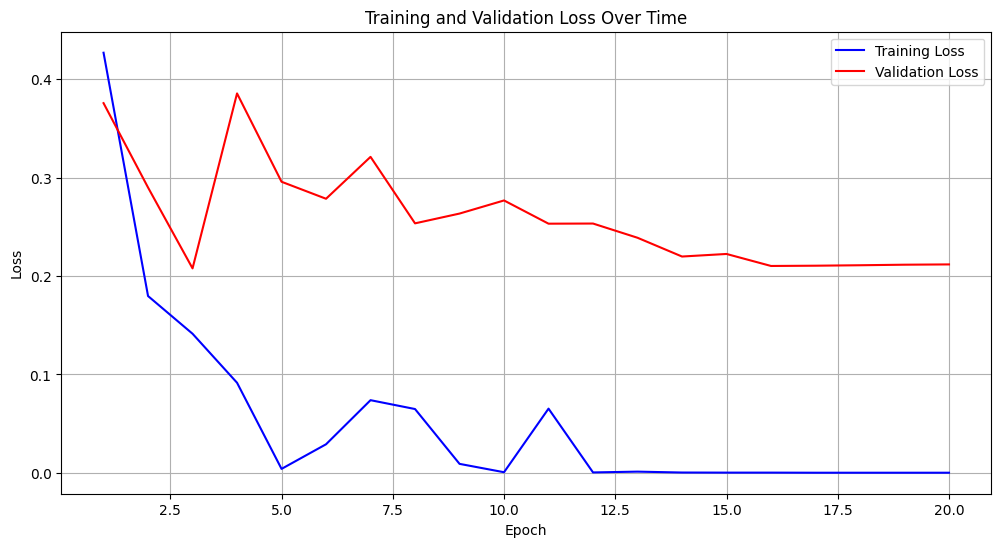

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd

# 1. Visualize Training Results
def plot_training_results(epochs, train_losses, val_losses):
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Process the results
epochs = list(range(1, 21))
train_losses = [0.4268, 0.1796, 0.1413, 0.0915, 0.0040, 0.0290, 0.0738, 0.0648, 
                0.0091, 0.0006, 0.0652, 0.0004, 0.0012, 0.0003, 0.0002, 0.0002, 
                0.0001, 0.0001, 0.0001, 0.0001]
val_losses = [0.375574, 0.289849, 0.207703, 0.385446, 0.295704, 0.278439, 0.321003, 
              0.253445, 0.263390, 0.276715, 0.253116, 0.253257, 0.238809, 0.219744, 
              0.222350, 0.210152, 0.210422, 0.210882, 0.211435, 0.211732]

# Plot the results
plot_training_results(epochs, train_losses, val_losses)

In [4]:
# Function for Testing on New Images
def predict_image(model, feature_extractor, image_path, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply the same transformations as during training
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=feature_extractor.image_mean,
            std=feature_extractor.image_std
        )
    ])
    
    # Preprocess image
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(pixel_values=image_tensor)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class_idx].item()
    
    return predicted_class_idx, confidence

def visualize_prediction(image_path, predicted_class, confidence, class_names):
    img = Image.open(image_path).convert('RGB')
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {class_names[predicted_class]}\nConfidence: {confidence:.2%}')
    plt.show()

In [5]:
# Function to test multiple images
def test_multiple_images(model, feature_extractor, image_paths, class_names, device):
    """
    Test the model on multiple images and display results
    """
    results = []
    
    for image_path in image_paths:
        pred_idx, confidence = predict_image(model, feature_extractor, image_path, device)
        results.append({
            'Image': os.path.basename(image_path),
            'Predicted Class': class_names[pred_idx],
            'Confidence': f"{confidence:.2%}"
        })
        visualize_prediction(image_path, pred_idx, confidence, class_names)
    
    # Display results in a table
    results_df = pd.DataFrame(results)
    display(results_df)

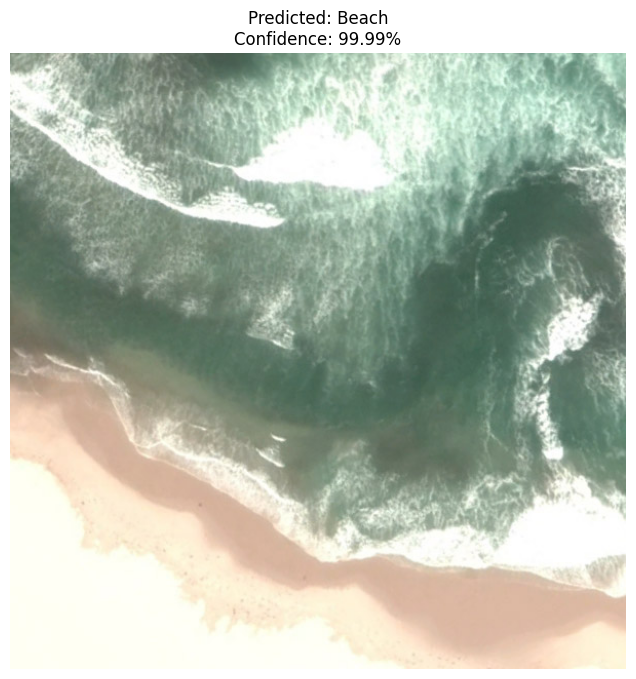

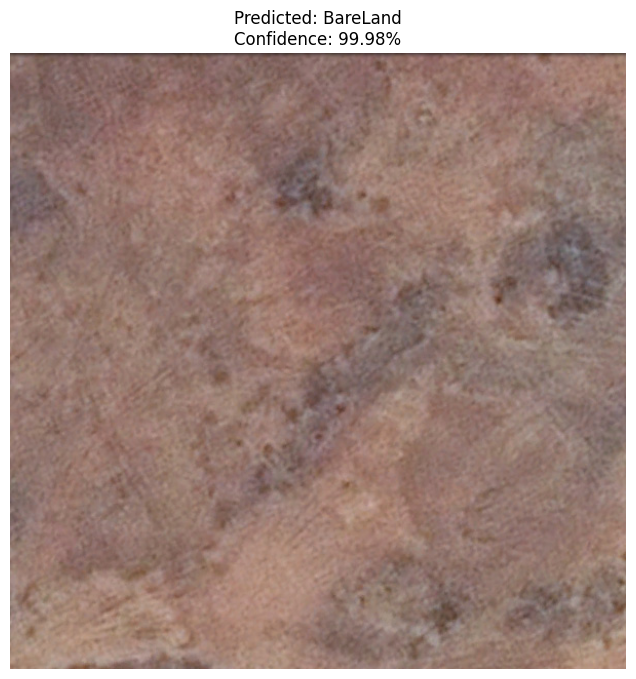

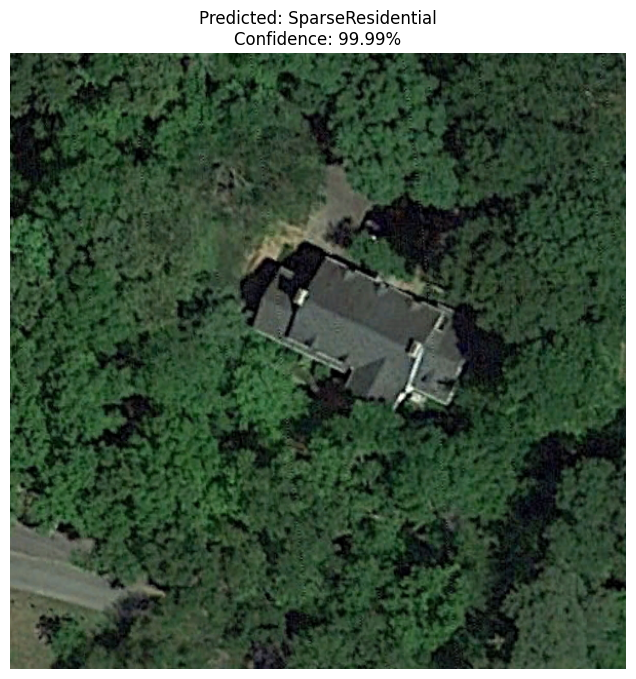

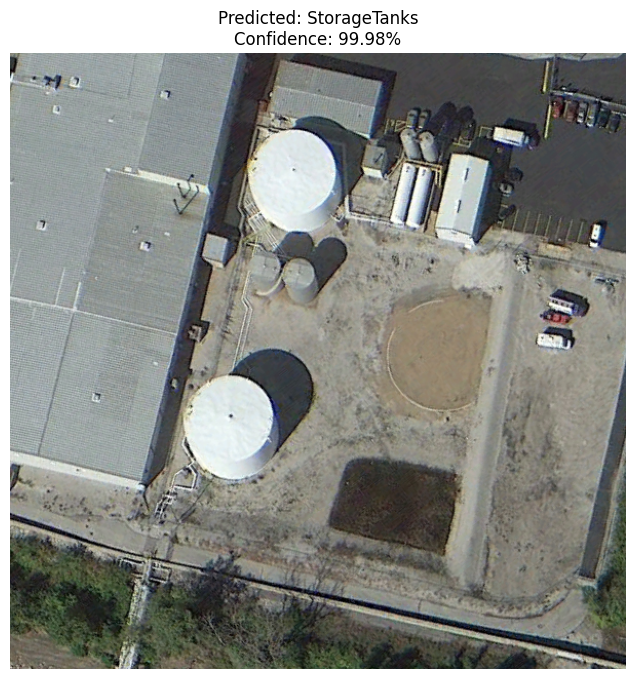

,Image,Predicted Class,Confidence
0,bareland_10.jpg,BareLand,99.98%
1,sparseresidential_10.jpg,SparseResidential,99.99%
2,storagetanks_101.jpg,StorageTanks,99.98%


In [6]:
image_path = "/kaggle/input/aid-scene-classification-datasets/AID/Beach/beach_100.jpg"
pred_idx, confidence = predict_image(model, feature_extractor, image_path, device)
visualize_prediction(image_path, pred_idx, confidence, dataset.classes)


test_image_paths = [
    "/kaggle/input/aid-scene-classification-datasets/AID/BareLand/bareland_10.jpg",
    "/kaggle/input/aid-scene-classification-datasets/AID/SparseResidential/sparseresidential_10.jpg",
    "/kaggle/input/aid-scene-classification-datasets/AID/StorageTanks/storagetanks_101.jpg"
]
test_multiple_images(model, feature_extractor, test_image_paths, dataset.classes, device)


# Create confusion matrix on validation set
def create_confusion_matrix(model, val_loader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            images = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs.logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
import shutil
shutil.make_archive('results/checkpoint-10000', 'zip', 'results/checkpoint-10000')

'/kaggle/working/results/checkpoint-10000.zip'

In [18]:
! rm -rf results/checkpoint-10000.zip